In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset

import tifffile
import trackpy as tp
import matplotlib.patches as patches

# Load Data

In [82]:
def get_PSF_frame(movie_frame, x, y, frame_size, keep_edges=False):
    half_frame = int(frame_size/2)
    int_x = round(x); int_y = round(y)
    lower_x = int_x - half_frame
    lower_y = int_y - half_frame
    upper_x = int_x + half_frame + 1
    upper_y = int_y + half_frame + 1
    upper_limit_x = movie_frame.shape[1]
    upper_limit_y = movie_frame.shape[0]
    if keep_edges:
        if lower_x < 0:
            lower_x = 0
        if lower_y < 0:
            lower_y = 0
        if upper_x > upper_limit_x:
            upper_x = upper_limit_x
        if upper_y > upper_limit_y:
            upper_y = upper_limit_y
    else:
        if lower_x < 0 or lower_y < 0 or upper_x > upper_limit_x or upper_y > upper_limit_y:
            return False
    return np.array(movie_frame)[lower_y:upper_y, lower_x:upper_x]

def get_PSF_frames(movie, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9, to_plot=False, movie_frames=True, dpi=100):
    if type(movie_frames) == bool:
        movie_frames = range(len(movie))
    
    # Initialize an empty list to store the PSF frames
    PSF_frames = []

    # Loop through each frame in the movie
    for i in movie_frames:
        # Perform localization on the frame
        full_frame = tp.locate(movie[i], diameter=diameter, 
                        minmass=minmass, max_iterations=10,
                        separation=separation, percentile=percentile)  # Adjust the minmass parameter as needed

        # Plot the frame with the identified features
        if to_plot:
            fig, ax = plt.subplots(1, dpi=dpi)
            ax.imshow(movie[i], cmap='gray')

        # Draw a box around each identified feature
        for index, row in full_frame.iterrows():
            if to_plot:
                rect = patches.Rectangle((row['x']-int(frame_size/2), row['y']-int(frame_size/2)), frame_size, frame_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            PSF_frame = get_PSF_frame(movie[i], row['x'], row['y'], frame_size)
            if type(PSF_frame) == bool:
                continue
            PSF_frames.append(PSF_frame)
        if to_plot:
            plt.title(f'Full Frame {i}')
            plt.show()

    # Convert the list of frames to a numpy array
    PSF_frames = np.array(PSF_frames)
    return PSF_frames

def show_PSFs(PSF_frames):
    print(PSF_frames.shape)
    num_PSFs = 15
    random_seed = 1 # random seed for reproducibility
    np.random.seed(random_seed)
    PSF_indices = np.random.choice(PSF_frames.shape[0], size=num_PSFs, replace=False)
    image_list = PSF_frames[PSF_indices]

    # Creating a 2x5 subplot grid
    fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=150)

    # Flattening the 2D array of axes to a 1D array
    axes = axes.flatten()

    # Iterating over each image and corresponding axis
    for i in range(len(axes)):
        # Displaying the image on the corresponding axis
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Examples of PSF Frames", fontsize=24)
    plt.tight_layout()
    plt.show()

## Good Data

In [5]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\Good Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_28mW.tif')
CF660_movie = tifffile.imread('Raw Data\Good Data\CF660c-GaM_No1CG_100EMG_50ms_28mW647_0mW405.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 500


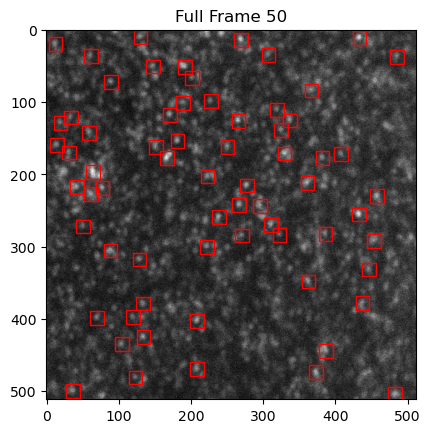

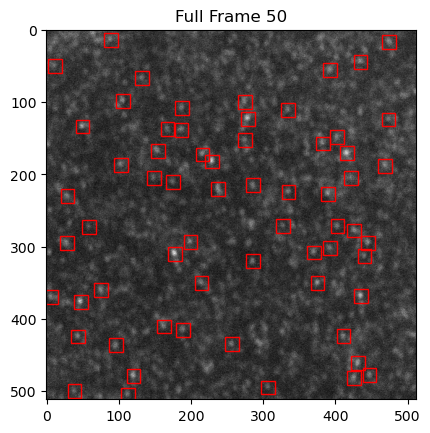

Produced 6598 PSFs for A647
Produced 27518 PSFs for CF660


In [20]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
# indices = [10, 500, 1000, 2000, 4000, 6000]
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
print(f"Produced {len(A647_PSF_frames)} PSFs for A647")
print(f"Produced {len(CF660_PSF_frames)} PSFs for CF660")

(6598, 19, 19)


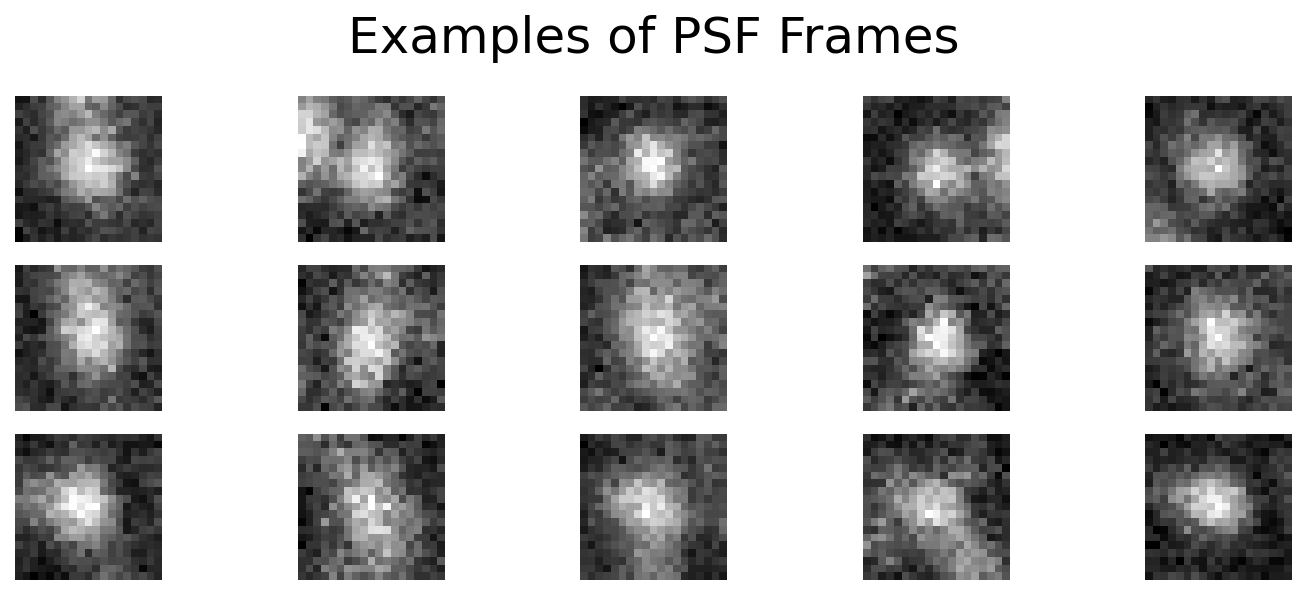

(27518, 19, 19)


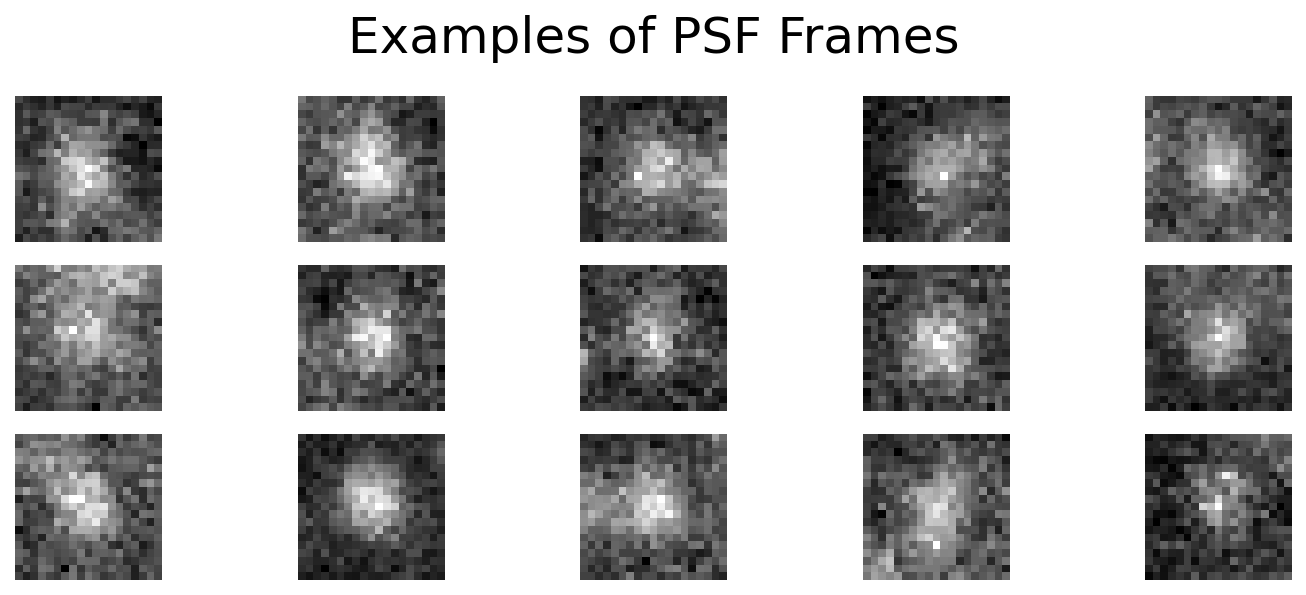

In [21]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


In [26]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [83]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_training = PSFDataset(True)
# make testing set
PSF_testing = PSFDataset(False)

print(len(PSF_training))
print(len(PSF_testing))

11216
1980


## Test Data

In [84]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_2_40mW.tif')
CF660_movie = tifffile.imread('Raw Data\CF660c-GaM_No1CG_100EMG_50ms_15mW647_0mW405_small.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes
<tifffile.TiffTag 5033 @135580> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 1000


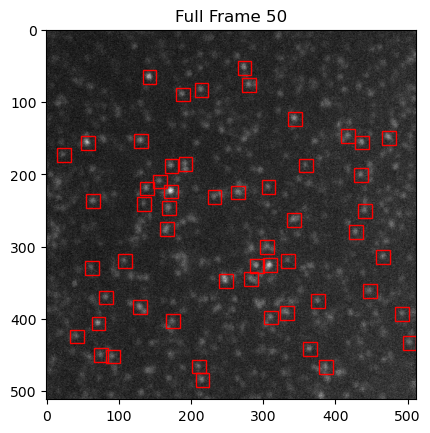

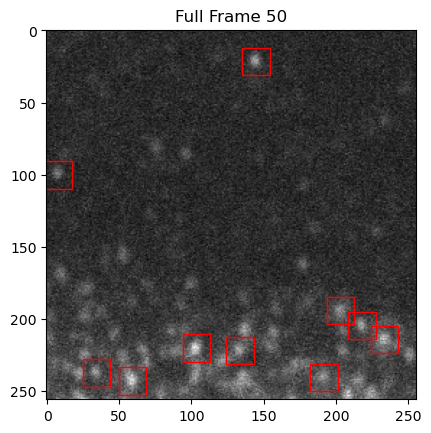

Produced 5730 PSFs for A647
Produced 5416 PSFs for CF660


In [85]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
# indices = [10, 500, 1000, 2000, 4000, 6000]
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
print(f"Produced {len(A647_PSF_frames)} PSFs for A647")
print(f"Produced {len(CF660_PSF_frames)} PSFs for CF660")

(5730, 19, 19)


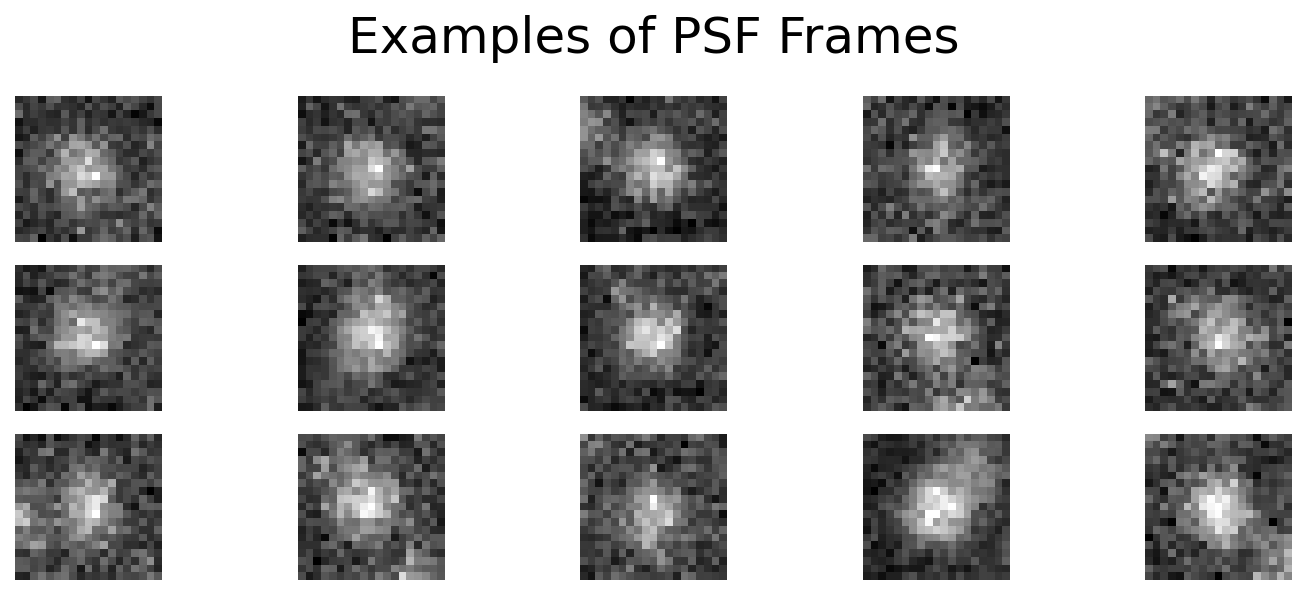

(5416, 19, 19)


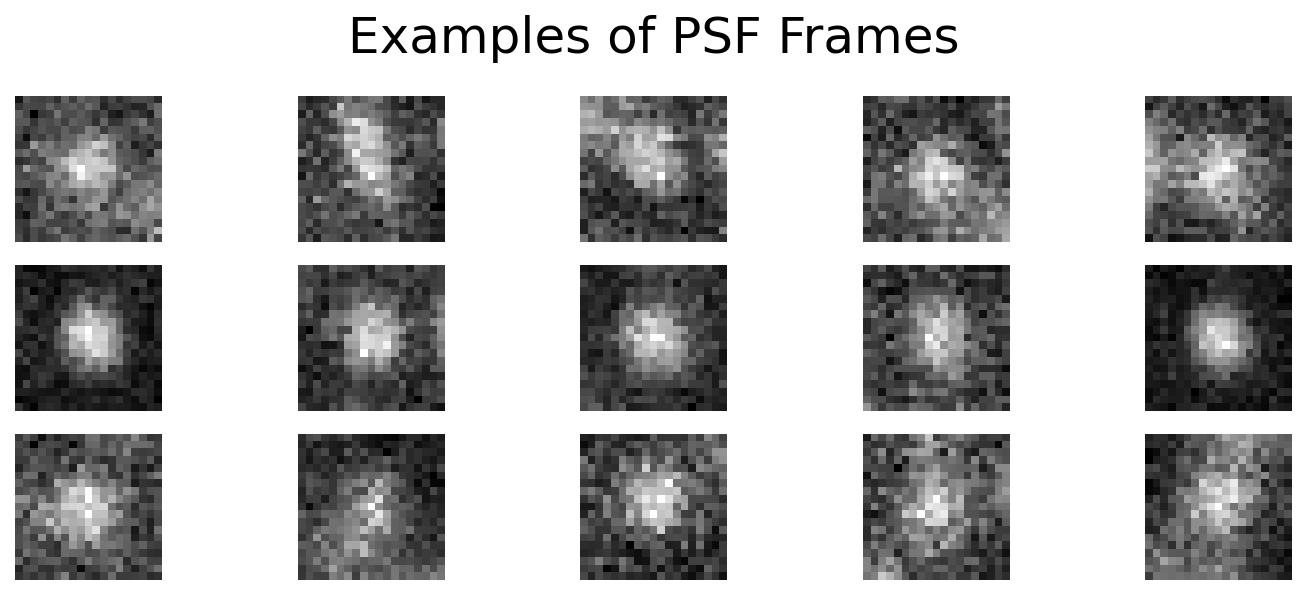

In [86]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [87]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [88]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]

# make training set
PSF_fresh_movies = PSFDataset(True)

print(len(PSF_fresh_movies))

9207


# Model Code

In [31]:
# model code for simple convolutional neural network
class CNN(nn.Module):
    # constructor
    def __init__(self, channel_widths, pooling, nonlinearity=nn.ReLU()):
        super(CNN, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            # convolution layer
            # you can play around with kernel_size, padding, and stride if you like
            # kernel_size is most likely to have an impact
            # arguments are: Conv2d(n_input_channels, n_output_channels, 
            #                       filter_side_length, padding, stride_length)
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity) # non-linearity
        # add final layer
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling # reduce each of the H x W feature maps to a single pooled value
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]
        self.linear = nn.Linear(channel_widths[-1]*self.pool_size, 2)  # score each class to obtain logits
    # forward pass
    def forward(self, x):
        B = x.size(0) # number of input images
        features = self.backbone(x) # get feature maps (B, N_feature_maps, H, W)
        pooled_features = self.global_pooling(features) # (B, N_feature_maps, 1, 1)
        pooled_features = pooled_features.view(B, -1) # (B, N_feature_maps)
        logits = self.linear(pooled_features) # (B, N_classes)
        return logits

In [32]:
# model code for simple convolutional nerual network followed by fully connected layers
class CNN_FC(nn.Module):
    # constructor
    def __init__(self, channel_widths, linear_sizes, pooling, nonlinearity=nn.ReLU()):
        super(CNN_FC, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
            layers.append(nonlinearity)
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=5, padding=2, stride=1, bias=False))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]

        # Defining the fully connected layers
        fc_layers = []
        in_features = channel_widths[-1]*self.pool_size
        for size in linear_sizes:
            fc_layers.append(nn.Linear(in_features, size))
            fc_layers.append(nonlinearity)
            in_features = size
        self.fully_connected = nn.Sequential(*fc_layers)

        self.linear = nn.Linear(in_features, 2)  # score each class to obtain logits

    # forward pass
    def forward(self, x):
        B = x.size(0)
        features = self.backbone(x)
        pooled_features = self.global_pooling(features)
        pooled_features = pooled_features.view(B, -1)
        fc_output = self.fully_connected(pooled_features)
        logits = self.linear(fc_output)
        return logits

In [34]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            test_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return test_acc/len(dataset)

In [40]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5500 # 100 examples per class
N_validation_examples = 5500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 1e-7,
          'n_epochs': 200,
          'batch_size': 200}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 16, 32, 64, 128, 256] # must start with a 1 and be at least length--2
model = CNN(channel_widths, pool_fcn)

# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 7.8207e-01, Acc = 0.5293, (Val) Loss = 7.8572e-01, Acc = 0.5251
Epoch 20/200: (Train) Loss = 7.4249e-01, Acc = 0.5638, (Val) Loss = 7.4450e-01, Acc = 0.5531
Epoch 30/200: (Train) Loss = 7.1277e-01, Acc = 0.5884, (Val) Loss = 7.1640e-01, Acc = 0.5833
Epoch 40/200: (Train) Loss = 6.9139e-01, Acc = 0.6082, (Val) Loss = 6.9332e-01, Acc = 0.6018
Epoch 50/200: (Train) Loss = 6.7158e-01, Acc = 0.6215, (Val) Loss = 6.7621e-01, Acc = 0.6178
Epoch 60/200: (Train) Loss = 6.6133e-01, Acc = 0.6393, (Val) Loss = 6.6403e-01, Acc = 0.6298
Epoch 70/200: (Train) Loss = 6.5038e-01, Acc = 0.6462, (Val) Loss = 6.5420e-01, Acc = 0.6367
Epoch 80/200: (Train) Loss = 6.3997e-01, Acc = 0.6509, (Val) Loss = 6.4735e-01, Acc = 0.6469
Epoch 90/200: (Train) Loss = 6.3346e-01, Acc = 0.6596, (Val) Loss = 6.3770e-01, Acc = 0.6542
Epoch 100/200: (Train) Loss = 6.2661e-01, Acc = 0.6645, (Val) Loss = 6.3308e-01, Acc = 0.6618
Epoch 110/200: (Train) Loss = 6.2145e-01, Acc = 0.6684, (Val) Loss = 

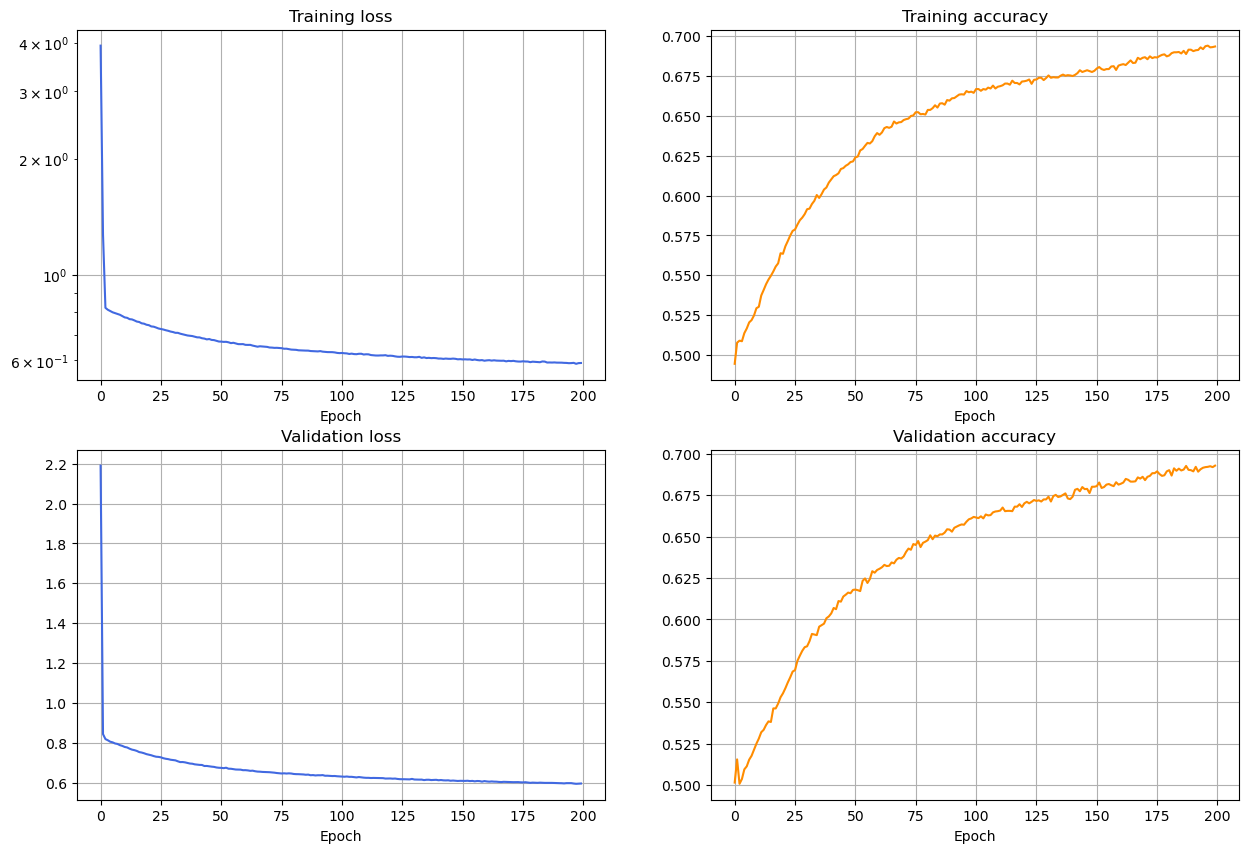

In [41]:
# plot training/validation loss and accuracy over training time
def plot_model_results():
    plt.figure(figsize=(15, 10))
    plt.subplot(221)
    plt.semilogy(train_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Training loss')
    plt.grid(True)
    plt.subplot(222)
    plt.plot(train_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Training accuracy')
    plt.grid(True)
    plt.subplot(223)
    plt.plot(val_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Validation loss')
    plt.grid(True)
    plt.subplot(224)
    plt.plot(val_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Validation accuracy')
    plt.grid(True)
plot_model_results()

In [34]:
print(test(model, PSF_testing))

0.716280701754386


In [47]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5500 # 100 examples per class
N_validation_examples = 5500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 1e-5,
          'n_epochs': 200,
          'batch_size': 200}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 32, 64, 128, 256] # must start with a 1 and be at least length--2
linear_sizes = [128, 64, 32]
model = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [52]:
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 4.5921e-01, Acc = 0.7985, (Val) Loss = 4.6395e-01, Acc = 0.7933
Epoch 20/200: (Train) Loss = 4.5735e-01, Acc = 0.7965, (Val) Loss = 4.6271e-01, Acc = 0.7875
Epoch 30/200: (Train) Loss = 4.5280e-01, Acc = 0.8011, (Val) Loss = 4.6214e-01, Acc = 0.7816
Epoch 40/200: (Train) Loss = 4.5453e-01, Acc = 0.8013, (Val) Loss = 4.6066e-01, Acc = 0.7824
Epoch 50/200: (Train) Loss = 4.5303e-01, Acc = 0.8022, (Val) Loss = 4.5823e-01, Acc = 0.8009
Epoch 60/200: (Train) Loss = 4.5027e-01, Acc = 0.8033, (Val) Loss = 4.5514e-01, Acc = 0.8000
Epoch 70/200: (Train) Loss = 4.4831e-01, Acc = 0.7985, (Val) Loss = 4.5463e-01, Acc = 0.7995
Epoch 80/200: (Train) Loss = 4.4815e-01, Acc = 0.8024, (Val) Loss = 4.5356e-01, Acc = 0.8027
Epoch 90/200: (Train) Loss = 4.4689e-01, Acc = 0.7991, (Val) Loss = 4.5347e-01, Acc = 0.8045
Epoch 100/200: (Train) Loss = 4.4654e-01, Acc = 0.8036, (Val) Loss = 4.5305e-01, Acc = 0.7813
Epoch 110/200: (Train) Loss = 4.4219e-01, Acc = 0.8029, (Val) Loss = 

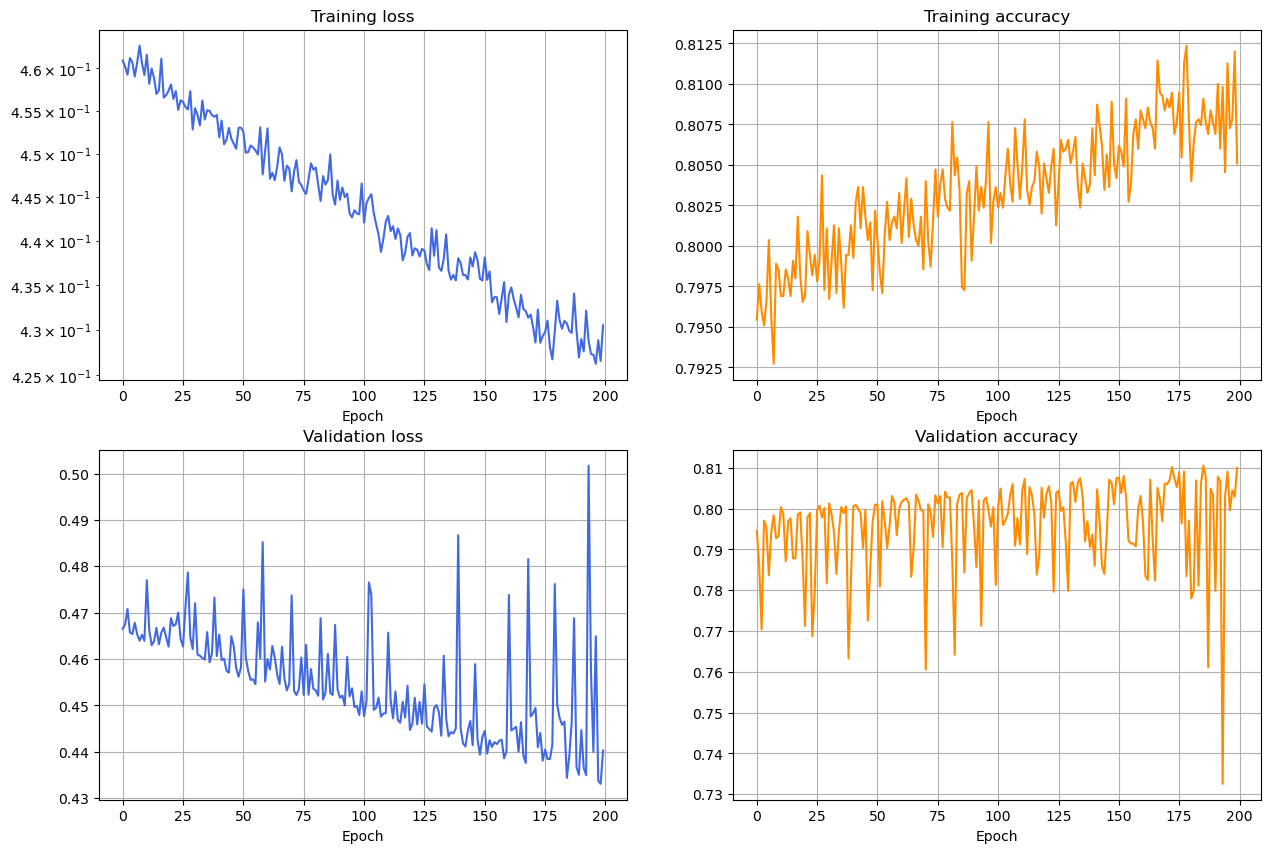

In [53]:
# plot training/validation loss and accuracy over training time
plot_model_results()

In [70]:
print(test(model, PSF_testing))
torch.save(model, 'Models/model2.pt')

0.8025252525252525


In [59]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5500 # 100 examples per class
N_validation_examples = 5500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
config = {'lr': 1e-2,
          'n_epochs': 200,
          'batch_size': 200}
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 32, 64, 128, 256, 512, 1028] # must start with a 1 and be at least length--2
linear_sizes = [512, 256, 128, 64, 32]
model_2 = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [60]:
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_2.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 6.5806e-01, Acc = 0.6087, (Val) Loss = 7.2432e-01, Acc = 0.4984
Epoch 20/200: (Train) Loss = 5.9491e-01, Acc = 0.6793, (Val) Loss = 5.3332e-01, Acc = 0.7505
Epoch 30/200: (Train) Loss = 5.4332e-01, Acc = 0.7315, (Val) Loss = 4.7518e-01, Acc = 0.7873
Epoch 40/200: (Train) Loss = 4.8876e-01, Acc = 0.7662, (Val) Loss = 4.6185e-01, Acc = 0.7813
Epoch 50/200: (Train) Loss = 4.7711e-01, Acc = 0.7658, (Val) Loss = 6.2119e-01, Acc = 0.7113
Epoch 60/200: (Train) Loss = 4.4704e-01, Acc = 0.7835, (Val) Loss = 3.9396e-01, Acc = 0.8235
Epoch 70/200: (Train) Loss = 4.3733e-01, Acc = 0.7813, (Val) Loss = 3.9114e-01, Acc = 0.8376
Epoch 80/200: (Train) Loss = 3.8541e-01, Acc = 0.8198, (Val) Loss = 3.7994e-01, Acc = 0.8242
Epoch 90/200: (Train) Loss = 3.8120e-01, Acc = 0.8244, (Val) Loss = 3.6774e-01, Acc = 0.8393
Epoch 100/200: (Train) Loss = 3.3149e-01, Acc = 0.8469, (Val) Loss = 5.9589e-01, Acc = 0.7160
Epoch 110/200: (Train) Loss = 5.1343e-01, Acc = 0.7871, (Val) Loss = 

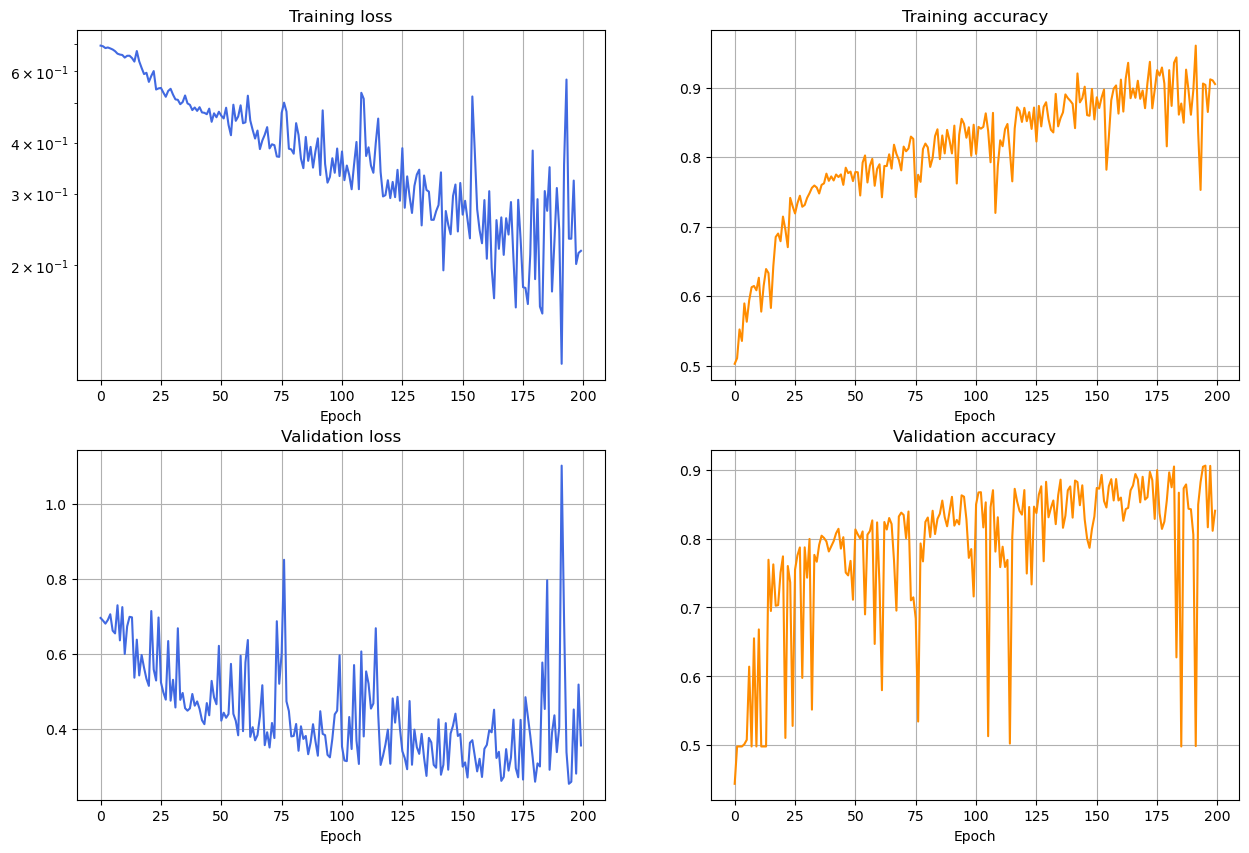

In [63]:
# plot training/validation loss and accuracy over training time
plot_model_results()

In [64]:
print(test(model_2, PSF_testing))
print(test(best_model, PSF_testing))

0.8343434343434344
0.8343434343434344


In [66]:
config = {'lr': 1e-2,
          'n_epochs': 20,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model_2 = train(model_2.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 2.8139e-01, Acc = 0.8907, (Val) Loss = 2.7409e-01, Acc = 0.9087
Epoch 2/20: (Train) Loss = 1.6012e-01, Acc = 0.9435, (Val) Loss = 6.0700e-01, Acc = 0.7695
Epoch 3/20: (Train) Loss = 1.0267e-01, Acc = 0.9589, (Val) Loss = 3.4502e-01, Acc = 0.8989
Epoch 4/20: (Train) Loss = 7.3246e-02, Acc = 0.9704, (Val) Loss = 3.7418e-01, Acc = 0.9096
Epoch 5/20: (Train) Loss = 2.3236e-01, Acc = 0.8958, (Val) Loss = 6.5998e-01, Acc = 0.5698
Epoch 6/20: (Train) Loss = 3.7068e-01, Acc = 0.8473, (Val) Loss = 2.4880e-01, Acc = 0.9076
Epoch 7/20: (Train) Loss = 1.7140e-01, Acc = 0.9347, (Val) Loss = 2.5405e-01, Acc = 0.9100
Epoch 8/20: (Train) Loss = 1.2572e-01, Acc = 0.9451, (Val) Loss = 3.2167e-01, Acc = 0.9136
Epoch 9/20: (Train) Loss = 1.8844e-02, Acc = 0.9951, (Val) Loss = 3.3583e-01, Acc = 0.9087
Epoch 10/20: (Train) Loss = 1.0188e-02, Acc = 0.9978, (Val) Loss = 3.8053e-01, Acc = 0.9169
Epoch 11/20: (Train) Loss = 4.7186e-03, Acc = 0.9996, (Val) Loss = 4.1096e-01, Acc = 0.91

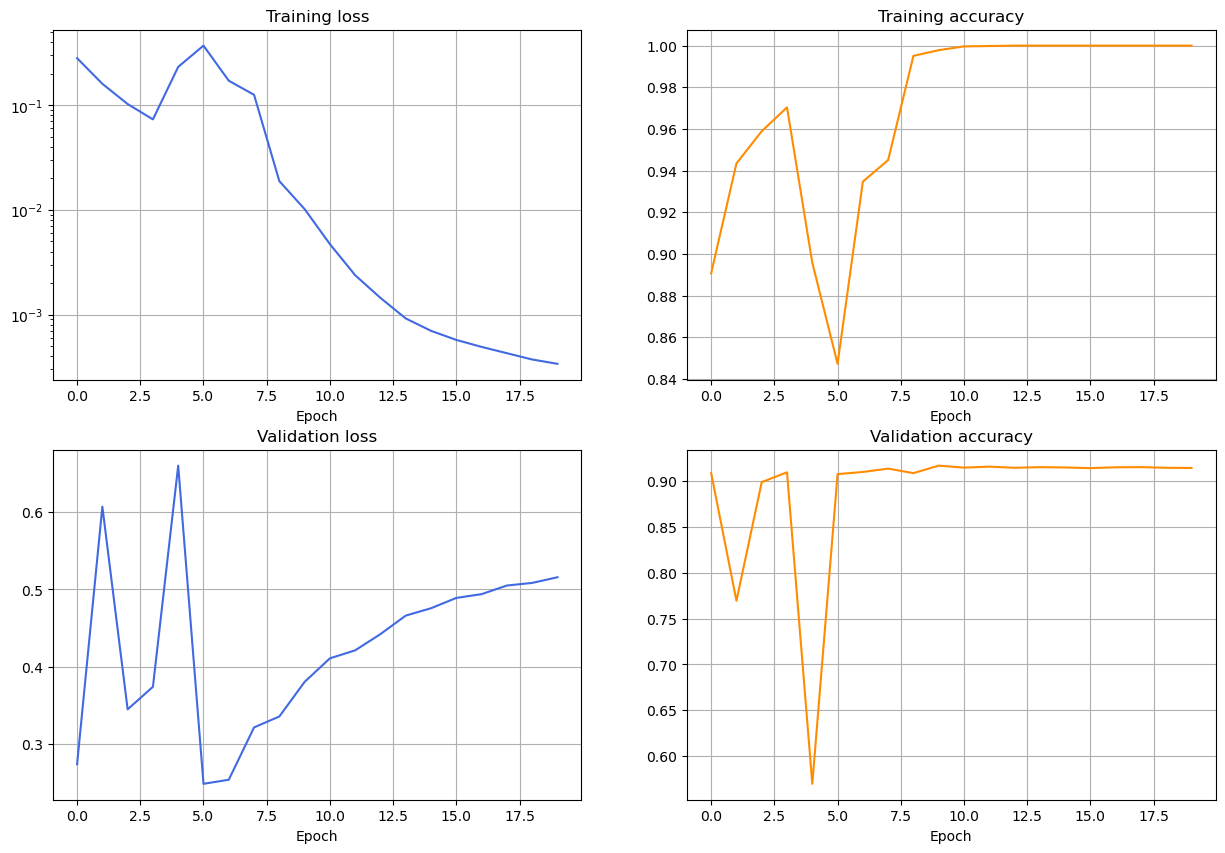

In [67]:
# plot training/validation loss and accuracy over training time
plot_model_results()

In [71]:
print(test(model_2, PSF_testing))
print(test(best_model_2, PSF_testing))
torch.save(model_2, 'Models/model3.pt')

0.8560606060606061
0.8560606060606061


In [89]:
print(test(model_2, PSF_fresh_movies))

0.527207559465624


In [76]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 5500 # 100 examples per class
N_validation_examples = 5500 # 100 examples per class
random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=N_training_examples+N_validation_examples)
training_indices = all_train_indices[:N_training_examples]
validation_indices = all_train_indices[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 64, 128, 256, 256, 256] # must start with a 1 and be at least length--2
linear_sizes = [256, 128, 64, 32]
model_4 = CNN_FC(channel_widths, linear_sizes, pool_fcn)

In [77]:
config = {'lr': 1e-2,
          'n_epochs': 200,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model_4 = train(model_4.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 6.4833e-01, Acc = 0.6460, (Val) Loss = 5.7922e-01, Acc = 0.7653
Epoch 20/200: (Train) Loss = 6.2352e-01, Acc = 0.6720, (Val) Loss = 5.9915e-01, Acc = 0.6633
Epoch 30/200: (Train) Loss = 5.8913e-01, Acc = 0.6991, (Val) Loss = 5.8152e-01, Acc = 0.6871
Epoch 40/200: (Train) Loss = 5.5028e-01, Acc = 0.7269, (Val) Loss = 5.8904e-01, Acc = 0.7636
Epoch 50/200: (Train) Loss = 4.9310e-01, Acc = 0.7575, (Val) Loss = 5.9961e-01, Acc = 0.6605
Epoch 60/200: (Train) Loss = 4.5277e-01, Acc = 0.7773, (Val) Loss = 4.2217e-01, Acc = 0.8113
Epoch 70/200: (Train) Loss = 4.6036e-01, Acc = 0.7847, (Val) Loss = 6.4979e-01, Acc = 0.6067
Epoch 80/200: (Train) Loss = 3.7827e-01, Acc = 0.8227, (Val) Loss = 4.6672e-01, Acc = 0.7356
Epoch 90/200: (Train) Loss = 3.8839e-01, Acc = 0.8195, (Val) Loss = 3.5503e-01, Acc = 0.8433
Epoch 100/200: (Train) Loss = 3.4290e-01, Acc = 0.8433, (Val) Loss = 3.5160e-01, Acc = 0.8402
Epoch 110/200: (Train) Loss = 3.9759e-01, Acc = 0.8122, (Val) Loss = 

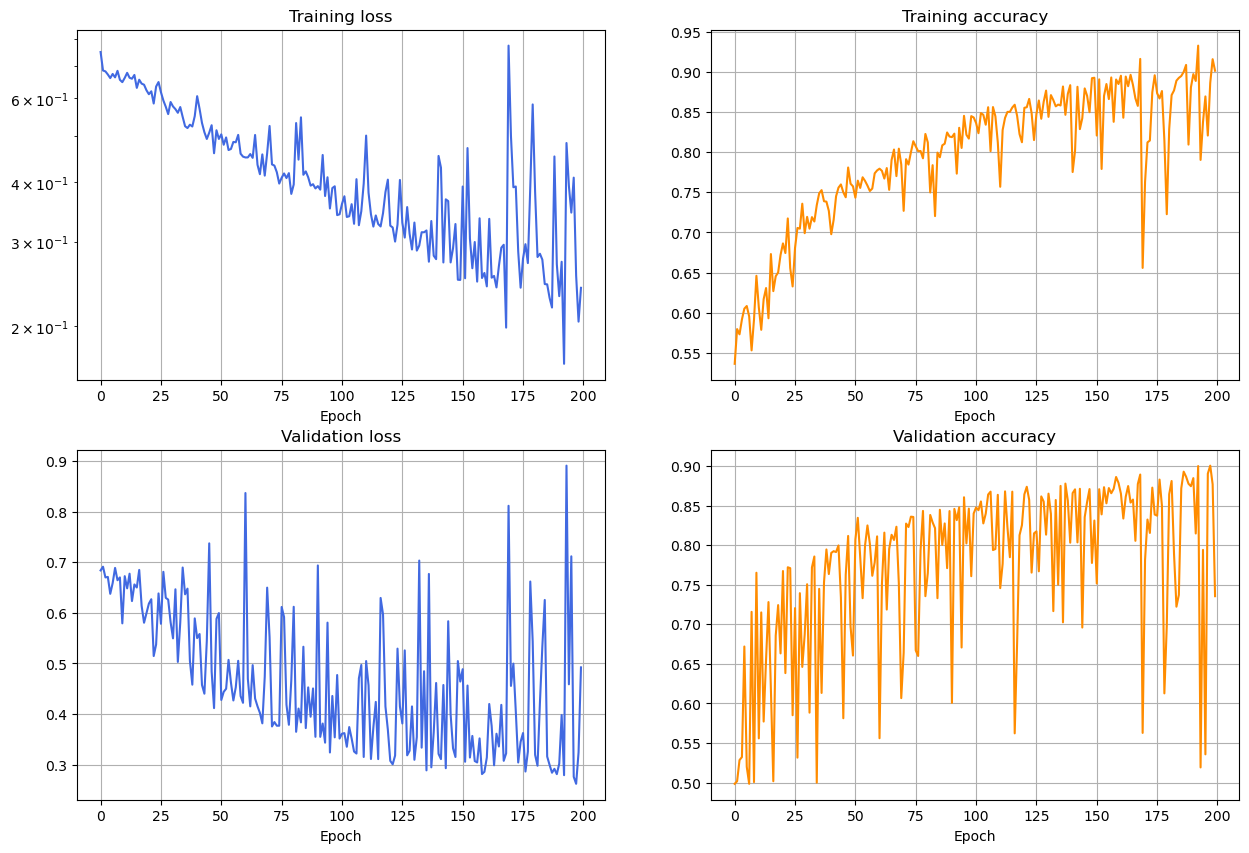

In [78]:
# plot training/validation loss and accuracy over training time
plot_model_results()

In [79]:
config = {'lr': 1e-4,
          'n_epochs': 200,
          'batch_size': 200}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model_4 = train(model_4.cuda(),
                                                                   PSF_training,
                                                                   training_indices,
                                                                   validation_indices,
                                                                   config,
                                                                   verbose=verbose)

Epoch 10/200: (Train) Loss = 1.7875e-01, Acc = 0.9415, (Val) Loss = 2.6958e-01, Acc = 0.8900
Epoch 20/200: (Train) Loss = 1.2630e-01, Acc = 0.9580, (Val) Loss = 2.5780e-01, Acc = 0.8978
Epoch 30/200: (Train) Loss = 1.1136e-01, Acc = 0.9620, (Val) Loss = 2.6388e-01, Acc = 0.9002
Epoch 40/200: (Train) Loss = 1.0292e-01, Acc = 0.9635, (Val) Loss = 2.6735e-01, Acc = 0.9011
Epoch 50/200: (Train) Loss = 9.7182e-02, Acc = 0.9642, (Val) Loss = 2.6968e-01, Acc = 0.9015
Epoch 60/200: (Train) Loss = 9.2869e-02, Acc = 0.9675, (Val) Loss = 2.6874e-01, Acc = 0.9029
Epoch 70/200: (Train) Loss = 8.8431e-02, Acc = 0.9693, (Val) Loss = 2.7190e-01, Acc = 0.9038
Epoch 80/200: (Train) Loss = 8.4713e-02, Acc = 0.9705, (Val) Loss = 2.7657e-01, Acc = 0.9056
Epoch 90/200: (Train) Loss = 8.2059e-02, Acc = 0.9727, (Val) Loss = 2.7613e-01, Acc = 0.9060
Epoch 100/200: (Train) Loss = 7.8799e-02, Acc = 0.9740, (Val) Loss = 2.7876e-01, Acc = 0.9064
Epoch 110/200: (Train) Loss = 7.6077e-02, Acc = 0.9753, (Val) Loss = 

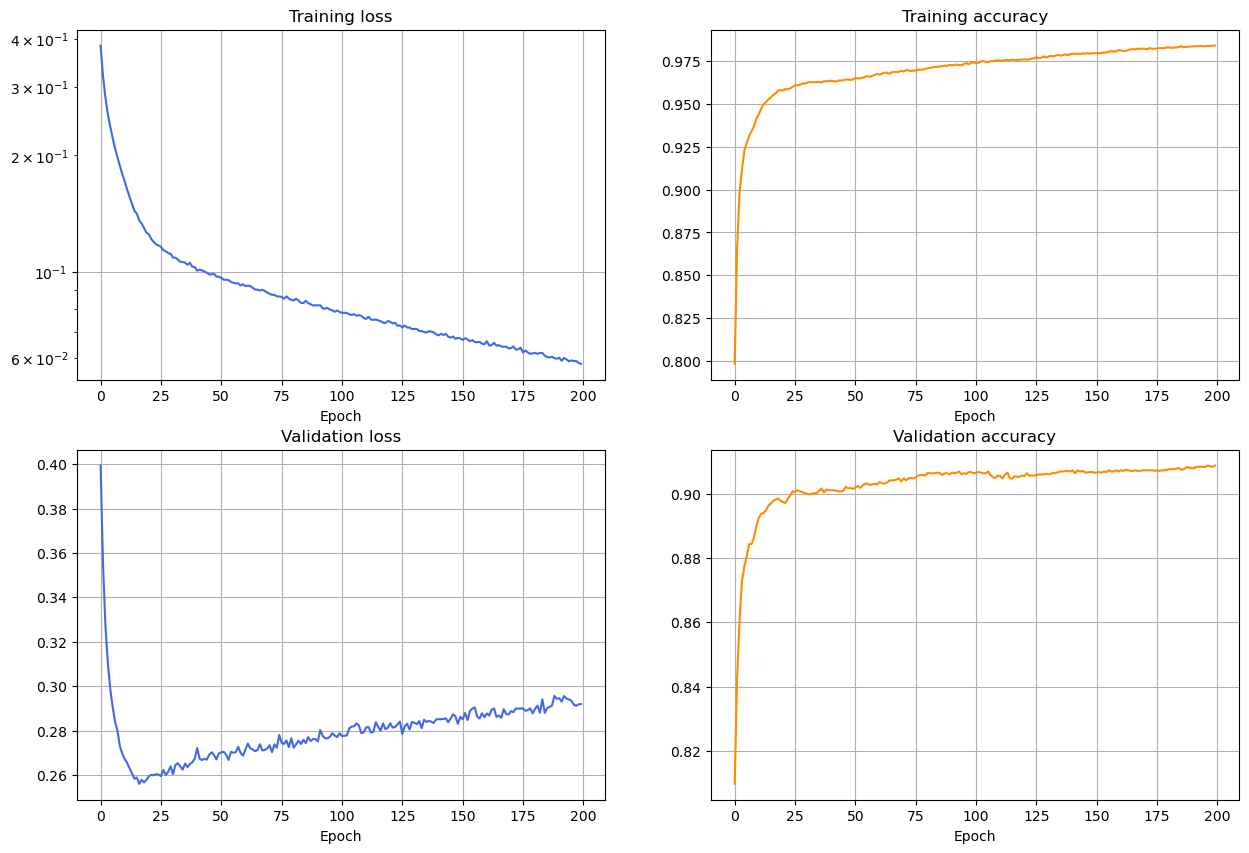

In [80]:
# plot training/validation loss and accuracy over training time
plot_model_results()

In [81]:
print(test(model_4, PSF_testing))
print(test(best_model_4, PSF_testing))
torch.save(model_4, 'Models/model4.pt')

0.8585858585858586
0.8585858585858586


In [90]:
print(test(best_model_4, PSF_fresh_movies))


0.5312262409036602
